In [200]:
%matplotlib inline
# standard-ish Qiskit libraries
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ

#Insert IBMQ account string here
#IBMQ.save_account('put code here',overwrite=True)


import time
import pickle


import numpy as np
import binascii
# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise



def flatten(l):
    return [item for sublist in l for item in sublist]

qiskit.__qiskit_version__

{'qiskit-terra': '0.9.1',
 'qiskit-ignis': '0.2.0',
 'qiskit': '0.12.2',
 'qiskit-aer': '0.3.0',
 'qiskit-ibmq-provider': '0.3.3',
 'qiskit-aqua': '0.6.0'}

In [201]:
#set parameters
local=False #run locally (simulation) or on IBM (actual quantum simulation)
#coupling_map_pair=[] #empty list if let compiler select which qubits to use
#coupling_map_pair=[[0,1]]  #set which qubits to use on machine, enter as a pair of two coupled together, must be of form [[0,1]] or [[0,1],[3,4]]

coupling_map_pair=[[0,1],[3,4]]  #set which qubits to use on machine, enter as a pair of two coupled together, must be of form [[0,1]] or [[0,1],[3,4]]




machine='ibmq_vigo'#which IBM machine to use #ibmqx2 #ibmq_vigo #'ibmq_ourense'#'ibmq_16_melbourne' #qasm_simulator
    
dataset="Test" #name of dataset


    

mode=0 #use which state preparation scheme, 0: maximal violation, 1: scheme with less violation 

if(mode!=0): #add mode to dataset name
    dataset+="m"+str(mode)

shots=2**13 #should not be larger than 8192 or 2**13
Nrepeatcircuits=0 #run all circuits how often. For zero, runs them the maximal amount, else specifiy. Maximal amount is limited by specific IBMQ machine
 
Nparallel=0 #number of parallel qubit pairs measured, set to zero to choose maximal value or choose according to layout

for i in range(len(coupling_map_pair)):
    if(len(coupling_map_pair[i])!=2):
        raise NameError("coupling_map_pair should be a list of consisting of a list of two numbers, e.g. [[0,1]] or [[0,1],[3,4]]")

initial_layout=flatten(coupling_map_pair) #layout of physical qubits used
if(len(initial_layout)>0): #add layout to dataset name
    dataset+="_I"
    for i in range(len(initial_layout)):
        dataset+="_"+str(initial_layout[i])
    
if(local==True): #flag dataset if run locally
    dataset="Simulated_"+dataset

dataset

'Test_I_0_1_3_4'

In [202]:
floatformat='02.7f' #format to print out floats
NmeasurementSettings=4 #number of circuits of Bell inequality
Nstates=4 #number of states measured
memory=True #get data of all shots



#Load credentials
IBMQ.load_account() 
if(local==True):
    backendRun = Aer.get_backend('qasm_simulator')
    #get noise and coupling map for simulation
    backend = IBMQ.get_provider().get_backend(machine)
    backendConfig=backend.configuration()
    properties = backend.properties()
    coupling_map = backendConfig.coupling_map
    noise_model = noise.device.basic_device_noise_model(properties)
    basis_gates = noise_model.basis_gates
    

else:
    backend = IBMQ.get_provider().get_backend(machine) #get IBM backend
    backendRun=backend
    backendConfig=backend.configuration()

if(Nrepeatcircuits==0):
    Nrepeatcircuits=backendConfig.max_experiments//NmeasurementSettings
    
if(memory==True):
    if(backendConfig.memory==False):
        raise NameError("Memory not supported by machine",machine)


NallCircuits=Nrepeatcircuits*NmeasurementSettings #should not be larger than backend.configuration().max_experiments
     
maxqubits=backendConfig.n_qubits #maximum number of qubits allowed in machine

if(Nparallel==0):
    if(len(initial_layout)==0):
        Nparallel=maxqubits//2
    else:
        Nparallel=len(initial_layout)//2




    
if(local==False):
    print("Max shots set",shots,", Max shots allowed",backendConfig.max_shots)
    print("repeated circuits (Nrepeatcircuits)",Nrepeatcircuits,", Maximum value allowed for Nrepeatcircuits",backendConfig.max_experiments//NmeasurementSettings)
    print("Number circuits set",NallCircuits,", Max circuits allowed",backendConfig.max_experiments)
    print("Parallel pairs measured is set",Nparallel,", Max allowed",maxqubits//2)
    if(shots>backendConfig.max_shots):
        raise NameError("shots number not supported by machine, reduce to",backendConfig.max_shots)
    if(NallCircuits>backendConfig.max_experiments):
        raise NameError("Number circuits too large, try reducing Nrepeatcircuits to",backendConfig.max_experiments//NmeasurementSettings)

    if(len(initial_layout)>maxqubits):
        raise NameError("Number of parallelized qubit pairs too large, try reducing initial_layout entries to",maxqubits)

    if(Nparallel>maxqubits):
        raise NameError("Number of parallelized qubit pairs too large, try reducing Nparallel to",maxqubits//2)

            
print("Bits Generated per run", Nparallel*NallCircuits*shots*2)

D:\Anaconda3\envs\qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


Max shots set 8192 , Max shots allowed 8192
repeated circuits (Nrepeatcircuits) 18 , Maximum value allowed for Nrepeatcircuits 18
Number circuits set 72 , Max circuits allowed 75
Parallel pairs measured is set 2 , Max allowed 2
Bits Generated per run 2359296


In [203]:
%qiskit_backend_overview

In [204]:
backend

<IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [205]:
propertiesQubits=backend.properties().qubits
readout_errorList=[]
for i in range(maxqubits):
    for j in range(len(propertiesQubits[i])):
        if(propertiesQubits[i][j].name=="readout_error"):
            readout_errorList.append(propertiesQubits[i][j].value)
couplingMapFull=np.unique(np.sort(backendConfig.coupling_map,axis=1),axis=0) #returns coupling map of only unique entries
propertiesGates=backend.properties().gates

cNotErrorList=[]
for i in range(len(propertiesGates)):
    for j in range(len(couplingMapFull)):
        if(np.all(np.array(propertiesGates[i].qubits)==couplingMapFull[j])):
            for k in range(len(propertiesGates[i].parameters)):
                if(propertiesGates[i].parameters[k].name=="gate_error"):
                    cNotErrorList.append([couplingMapFull[j],propertiesGates[i].parameters[k].value])


CNOTsUsedError=[]
for i in range(len(coupling_map_pair)):
    for j in range(len(couplingMapFull)):
        if(np.all(cNotErrorList[j][0]==np.sort(coupling_map_pair[i]))):
            CNOTsUsedError.append([i,coupling_map_pair[i],cNotErrorList[j][1]])
            print(i,coupling_map_pair[i],"CNOT Error",cNotErrorList[j][1] )

QubitsUsedMeasurementError=[]
for i in range(len(coupling_map_pair)):
    for j in range(2):
        QubitsUsedMeasurementError.append([2*i+j,coupling_map_pair[i][j],readout_errorList[coupling_map_pair[i][j]]])
        print("Readout Error of qbit number",2*i+j,"physical position",coupling_map_pair[i][j],"Error",readout_errorList[coupling_map_pair[i][j]])

0 [0, 1] CNOT Error 0.008854620731233304
1 [3, 4] CNOT Error 0.008408688767908706
Readout Error of qbit number 0 physical position 0 Error 0.08099999999999996
Readout Error of qbit number 1 physical position 1 Error 0.030000000000000027
Readout Error of qbit number 2 physical position 3 Error 0.030000000000000027
Readout Error of qbit number 3 physical position 4 Error 0.03300000000000003


In [206]:
Stheory=2*np.sqrt(2) #theoretic maximal value for CHSH inequality
circuitstring=['00','01','10','11'] #measurement settings
dictStates=['00','01','10','11'] #output states of two pairs



#The states outputed by the IBM machine are encoded as hex integer, and order of qubits is reversed, e.g. qubit 0 corresponds to last bit of state. Here, we reverse the order to get the right result, e.g. first physical qubit corresponds to first bit of state
orderStates=[] #maps hex numbers from memory into state string with right order, first qubit corresponds to first bit in state string
allStates=[] #all states measured in circuit
for i in range(Nstates**Nparallel):
    orderStates.append(format(i, '0'+str(Nparallel*2)+'b')[::-1]) #reverse order to fix inverse numbering output by IBM machine
    #memoryOrderStates.append(format(i, '0'+str(Nparallel*2)+'b'))
    allStates.append(format(i, '0'+str(Nparallel*2)+'b'))
    
#sets all states k to one that identify with state of pair j for parallel measured qubit pair i mapStatesToParallel[i][j][k]
mapStatesToParallel=np.zeros([Nparallel,NmeasurementSettings,Nstates**Nparallel])
for i in range(Nparallel):
    for j in range(Nstates):
        for k in range(Nstates**Nparallel):
            if(allStates[k][2*i:2*(i+1)]==dictStates[j]):
                mapStatesToParallel[i][j][k]=1

                
                


#maps measurement results for two quibit measurement 0 or 1 to either +1 or -1. This is used to generate the expectation value.
#stands for bit result ket(00) --> 1, ket(01)-->-1  ket(10)-->-1 ket(11)-->1
mappingBitResultToPM=np.array([1,-1,-1,1]) 

#define CHSHS inequality. We have 4 terms ZZ, ZX, XZ, XX, each generated by one of the circuits. We now assign three terms with +1, and one with -1. 
# The factors are multiplied with the average value of the respective circuits
if(mode==0):
    CHSHfactors=np.array([1,1,1,-1])
elif(mode==1):
    CHSHfactors=np.array([1,1,-1,1])



qr=[None for i in range(NmeasurementSettings)]
cr=[None for i in range(NmeasurementSettings)]
circuit=[None for i in range(NmeasurementSettings)]

#first step generates Bell state 00 + 11 by using a Hadamard and CNOT

for i in range(NmeasurementSettings):
    qr[i] = QuantumRegister(2*Nparallel, 'qr'+str(i))
    cr[i] = ClassicalRegister(2*Nparallel, 'cr'+str(i))
    circuit[i] = QuantumCircuit(qr[i], cr[i])
    for j in range(Nparallel):
        circuit[i].h(qr[i][2*j])
        circuit[i].cx(qr[i][2*j], qr[i][2*j+1])

    #Next, implement measurements settings
    #Here, we generate circuits that implement rotations in the desired basis, and then measure in the computation basis
    #two ways to generate CHSH circuit
if(mode==0): #maximal violation
#four measurement settings, generate four circuits
    #ZW
    current=0
    for j in range(Nparallel):
        circuit[current].s(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])
        circuit[current].t(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])

    #ZV
    current=1
    for j in range(Nparallel):
        circuit[current].s(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])
        circuit[current].tdg(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])


    #XW
    current=2
    for j in range(Nparallel):
        circuit[current].h(qr[current][2*j])
        circuit[current].s(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])
        circuit[current].t(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])

    #ZV
    current=3
    for j in range(Nparallel):
        circuit[current].h(qr[current][2*j])
        circuit[current].s(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])
        circuit[current].tdg(qr[current][2*j+1])
        circuit[current].h(qr[current][2*j+1])

elif(mode==1): #does not generate maximal violation, only up to 2.77
    theta=-3*np.pi/16
    for i in range(NmeasurementSettings):
        for j in range(Nparallel):
            circuit[i].u3(theta,0,0,qr[i][2*j])

    #ZZ gate
    #ZX gate
    for j in range(Nparallel):
        circuit[1].h(qr[1][2*j+1])

        #XZ gate
        circuit[2].h(qr[2][2*j])

        #XX
        circuit[3].h(qr[3][2*j])
        circuit[3].h(qr[3][2*j+1])
    
    
    
for i in range(NmeasurementSettings):
    circuit[i].barrier()
#generate circuits with measurements
circuitMeas=[circuit[i].copy() for i in range(NmeasurementSettings)] 
for i in range(NmeasurementSettings):
    circuitMeas[i].measure(qr[i], cr[i])
    
for i in range(NmeasurementSettings):
    print(circuit[i].draw()) #draw circuits without measurements

          ┌───┐                          ░ 
qr0_0: |0>┤ H ├──■───────────────────────░─
          └───┘┌─┴─┐┌───┐┌───┐┌───┐┌───┐ ░ 
qr0_1: |0>─────┤ X ├┤ S ├┤ H ├┤ T ├┤ H ├─░─
          ┌───┐└───┘└───┘└───┘└───┘└───┘ ░ 
qr0_2: |0>┤ H ├──■───────────────────────░─
          └───┘┌─┴─┐┌───┐┌───┐┌───┐┌───┐ ░ 
qr0_3: |0>─────┤ X ├┤ S ├┤ H ├┤ T ├┤ H ├─░─
               └───┘└───┘└───┘└───┘└───┘ ░ 
 cr0_0: 0 ═════════════════════════════════
                                           
 cr0_1: 0 ═════════════════════════════════
                                           
 cr0_2: 0 ═════════════════════════════════
                                           
 cr0_3: 0 ═════════════════════════════════
                                           
          ┌───┐                            ░ 
qr1_0: |0>┤ H ├──■─────────────────────────░─
          └───┘┌─┴─┐┌───┐┌───┐┌─────┐┌───┐ ░ 
qr1_1: |0>─────┤ X ├┤ S ├┤ H ├┤ Tdg ├┤ H ├─░─
          ┌───┐└───┘└───┘└───┘└─────┘└───┘ ░ 
qr1_2: |0>┤ H ├──■────

In [207]:
plotmeas=3
fig=circuitMeas[plotmeas].draw()
fig

In [208]:
# Run the quantum circuit on a statevector simulator backend
sv_simulator = Aer.get_backend('statevector_simulator')

#to generate state, use circuits without measurement
outputvector=[None for i in range(NmeasurementSettings)]
for i in range(NmeasurementSettings):
    # Execute the circuit
    jobStatevector = execute(circuit[i], sv_simulator)

    # Get the result
    resultStatevector = jobStatevector.result()
    outputstate = resultStatevector.get_statevector(circuit[i], decimals=20)
    outputvector[i]=outputstate
    
#print(outputvector)



probabilities=np.abs(np.array(outputvector))**2 #probablities of all states

#map probabilities to one pair of 00,01,10,11
probabilitiesMappedToPair=[np.sum(np.sum(mapStatesToParallel,axis=0)*probabilities[i],axis=1)/Nparallel for i in range(NmeasurementSettings)]

theoryCountsMappedToPair=[{} for i in range(NmeasurementSettings)]
for i in range(NmeasurementSettings):
    for m in range(Nstates):
        theoryCountsMappedToPair[i][dictStates[m]]=probabilitiesMappedToPair[i][m]

mappedtoZZ=probabilitiesMappedToPair*mappingBitResultToPM #map each state to a expectation Value of ZZ
summedOverEachTerm=np.sum(mappedtoZZ,axis=1) #sum over result of each measurement Setting
S=np.sum(summedOverEachTerm*CHSHfactors) #mulitiply with CHSH factors
[S,Stheory,Stheory-S,probabilitiesMappedToPair] #outputs inequality, theory value, difference between output and thoery, and the probabilities of each circuit


[2.8284271247461925,
 2.8284271247461903,
 -2.220446049250313e-15,
 [array([0.4267767, 0.0732233, 0.0732233, 0.4267767]),
  array([0.4267767, 0.0732233, 0.0732233, 0.4267767]),
  array([0.4267767, 0.0732233, 0.0732233, 0.4267767]),
  array([0.0732233, 0.4267767, 0.4267767, 0.0732233])]]

In [209]:
#we run the NmeasurementSettings each Nrepeatcircuits times to generate more data per run on the IBM machine
allcircuits=flatten([[circuitMeas[j].copy() for j in range(NmeasurementSettings)] for i in range(Nrepeatcircuits)])
for i in range(Nrepeatcircuits):
    for j in range(NmeasurementSettings):
        allcircuits[i*NmeasurementSettings+j].name="CircuitSetting"+str(j)+"Repeat"+str(i)
        
        
"""
#generate transpiler
if(len(initial_layout)==0):
    trans=transpile(allcircuits,backend)#,initial_layout=[0,1]
else:
    trans=transpile(allcircuits,backend,initial_layout=initial_layout)
"""

'\n#generate transpiler\nif(len(initial_layout)==0):\n    trans=transpile(allcircuits,backend)#,initial_layout=[0,1]\nelse:\n    trans=transpile(allcircuits,backend,initial_layout=initial_layout)\n'

In [210]:
#jobIBMqx2 = execute(circuitMeas, ibmqx2, shots=shots,memory=True)#,meas_return='single',meas_level=0
starttime=time.time()
if(local==True):
    print("Run with noise models of",machine,"locally")
    if(len(initial_layout)==0):
        job = execute(allcircuits, backendRun, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates)
    else:
        job = execute(allcircuits, backendRun, shots=shots,memory=memory,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates,initial_layout=initial_layout)
else:
    print("Run on IBM backend",machine)
    if(len(initial_layout)==0):
        print("Run without initial_layout")
        job =execute(allcircuits,backendRun, shots=shots,memory=memory)
    else:
        print("Run with initial_layout",initial_layout)
        job =execute(allcircuits,backendRun, shots=shots,memory=memory,initial_layout=initial_layout)

    print("IBM time to submit to queue",time.time()-starttime)

Run on IBM backend ibmq_vigo
Run with initial_layout [0, 1, 3, 4]
IBM time to submit to queue 7.185425519943237


In [211]:
# Grab the results from the job.
print("Waiting for job to finish and retrieve data")
starttime=time.time()
result = job.result()
waittime=time.time()-starttime
print("Final wait time",time.time()-starttime)
time_taken=result.time_taken
date=result.date
print("Time taken to run on machine",time_taken)

Waiting for job to finish and retrieve data
Final wait time 691.918653011322
Time taken to run on machine 633.8586142063141


In [212]:
totalshots=shots*Nrepeatcircuits #total shots for each measurement setting
counts=[{} for i in range(NmeasurementSettings)] #store counts for each measurement state here
countsPairState=[[{} for i in range(NmeasurementSettings)] for p in range(Nparallel)] #store counts for each measurement state here
for i in range(NmeasurementSettings):
    for m in range(len(allStates)):
        counts[i][allStates[m]]=0
countsVec=[None for i in range(NmeasurementSettings)] #counts ordered in a numpy vector
measuredProbablity=[None for i in range(NmeasurementSettings)] #counts normalized to one 
measuredProbabilityPairState=np.zeros([Nparallel,NmeasurementSettings,Nstates])
shotsResult=[[None for i in range(NmeasurementSettings)] for p in range(Nparallel)] #outputs 0 or 1 for each measurement result
measSetting=[[None for i in range(NmeasurementSettings)] for p in range(Nparallel)]#outputs 0 or 1 for each measurement Setting applied

print("Start evaluation of data")

for i in range(NmeasurementSettings):#add up counts from each measurement
    for k in range(Nrepeatcircuits): #add up counts from each repeated measurement setting
        for m in range(Nstates**Nparallel):
            tempgetcounts=result.get_counts(k*NmeasurementSettings+i)
            if(allStates[m] in tempgetcounts):
                counts[i][orderStates[m]]+=tempgetcounts[allStates[m]]  #maps get_counts, which uses inverse ordering of statestring to right state string order, e.g. (1100) is mapped to (0011)
            else:
                print("Warning: entry ",allStates[m],"for circuit",k*NmeasurementSettings+i,"is zero")
            #if(allStates[m] in result.get_counts(k*NmeasurementSettings+i)):
            #    counts[i][allStates[m]]+=result.get_counts(k*NmeasurementSettings+i)[allStates[m]] 
            #else:
            #    print("Warning: entry ",allStates[m],"for circuit",k*NmeasurementSettings+i,"is zero")
        
#        if(k==0):
#            counts[i] = result.get_counts(k*NmeasurementSettings+i)
#        else:
#            for m in range(Nstates):
#                counts[i][dictStates[m]]+=result.get_counts(k*NmeasurementSettings+i)[dictStates[m]]

                    
    #print(counts[i])
    countsVec[i]=np.array([counts[i][allStates[j]] if allStates[j] in counts[i] else 0 for j in range(len(allStates))]) #get counts into a numpy array
    measuredProbablity[i]=countsVec[i]/np.sum(countsVec[i]) #measured probablity distribution
    
    for p in range(Nparallel):
        measuredProbabilityPairState[p,i,:]=np.sum(measuredProbablity[i]*mapStatesToParallel[p,:,:],axis=1)
        for m in range(len(dictStates)):
            countsPairState[p][i][dictStates[m]]=measuredProbabilityPairState[p,i,m]
    
    if(memory==True): #get actual results for each shot
        for k in range(Nrepeatcircuits):
            if(k==0):
                memoryResult=result.data(k*NmeasurementSettings+i)['memory'] #list of which state has been measured in hex format
            else:
                memoryResult+=result.data(k*NmeasurementSettings+i)['memory']
        for p in range(Nparallel):
            shotsResult[p][i]=[orderStates[int(memoryResult[j],16)][2*p:2*(p+1)] for j in range(totalshots)] #convert hex to int, then reorder states to canonical format and give string
            measSetting[p][i]=[circuitstring[i] for j in range(totalshots)] #record measurement setting

SResult=[]
compareExact=[]
for p in range(Nparallel):
    mappedtoZZResult=measuredProbabilityPairState[p]*mappingBitResultToPM #multiply probablity distribution with prefactor of expectation value of <ZZ>
    summedOverEachTermResult=np.sum(mappedtoZZResult,axis=1) #get each term of the inequality
    SResult.append(np.sum(summedOverEachTermResult*CHSHfactors)) #multiply terms of inequality with prefactor of CHSH

    compareExact.append([np.transpose([measuredProbabilityPairState[p,i],probabilitiesMappedToPair[i]]) for i in range(NmeasurementSettings)]) #compares result of each state for each measurementSetting against theory result

    print("For parallel qubit pair",p,"inequality measured",SResult[p],"Theoretic value",Stheory,"Difference",Stheory-SResult[p])

print("Shows experiment and theory for each measurement setting and state")
print("[measured probability, theoretic probability]")
for p in range(Nparallel):
    print("Parallel qubit pair",p)
    for i in range(NmeasurementSettings):
        print("Measurement setting",i)
        print(compareExact[p][i])

Start evaluation of data
For parallel qubit pair 0 inequality measured 2.330295138888889 Theoretic value 2.8284271247461903 Difference 0.49813198585730145
For parallel qubit pair 1 inequality measured 2.525851779513889 Theoretic value 2.8284271247461903 Difference 0.30257534523230145
Shows experiment and theory for each measurement setting and state
[measured probability, theoretic probability]
Parallel qubit pair 0
Measurement setting 0
[[0.43065728 0.4267767 ]
 [0.10080295 0.0732233 ]
 [0.10038927 0.0732233 ]
 [0.3681505  0.4267767 ]]
Measurement setting 1
[[0.45758735 0.4267767 ]
 [0.07456462 0.0732233 ]
 [0.10829671 0.0732233 ]
 [0.35955132 0.4267767 ]]
Measurement setting 2
[[0.40144179 0.4267767 ]
 [0.08249919 0.0732233 ]
 [0.13218859 0.0732233 ]
 [0.38387044 0.4267767 ]]
Measurement setting 3
[[0.14146593 0.0732233 ]
 [0.34104411 0.4267767 ]
 [0.42284478 0.4267767 ]
 [0.09464518 0.0732233 ]]
Parallel qubit pair 1
Measurement setting 0
[[0.41400825 0.4267767 ]
 [0.12380642 0.0732

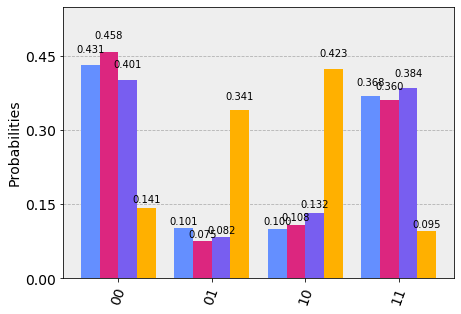

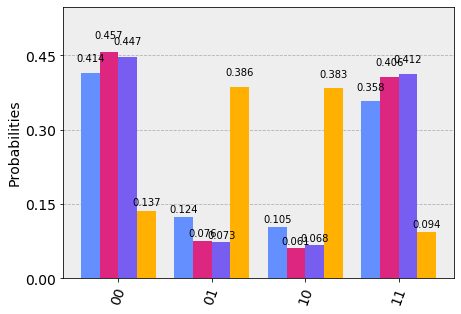

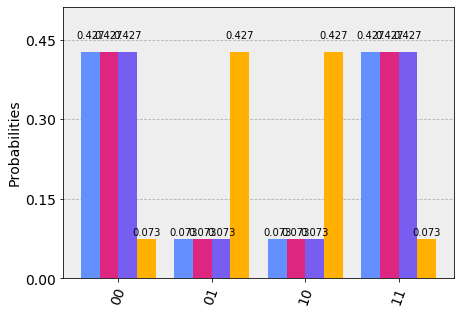

In [213]:
#histogram of measured counts, for each term of the inequality
for p in range(Nparallel):
    fig=plot_histogram(countsPairState[p])
    fig.savefig("Hist_"+machine+"_"+dataset+"_p"+str(p)+"_S"+format(SResult[p],floatformat).replace(".","_")+".pdf")
    display(fig)

fig=plot_histogram(theoryCountsMappedToPair) 
fig.savefig("Hist_"+"theory"+"_"+dataset+".pdf")
display(fig)


In [214]:
#Output data

resultA=[[] for i in range(Nparallel)] #alice measuremnt result
resultB=[[] for i in range(Nparallel)] #bob measurement result
measSettingA=[[] for i in range(Nparallel)] #alice measurement Setting
measSettingB=[[] for i in range(Nparallel)] #bob measurement Setting

if(memory==True):
    for p in range(Nparallel):
        print("Output qubit pair",p,"of parallel run")
        print("Generating output bits of measurement results and settings for Alice and Bob")
        shuffleCircuits=flatten([np.ones(totalshots,dtype=int)*i for i in range(NmeasurementSettings)]) #shuffle differen measurement types
        np.random.shuffle(shuffleCircuits)
        for i in range(NmeasurementSettings):
            for j in range(totalshots):
                circuitindex=shuffleCircuits[i*totalshots+j] #use shuffled index
                resultA[p]+=shotsResult[p][circuitindex][j][0]
                resultB[p]+=shotsResult[p][circuitindex][j][1]
                measSettingA[p]+=measSetting[p][circuitindex][j][0]
                measSettingB[p]+=measSetting[p][circuitindex][j][1]

                #output 
        #first file contains Alice Result, Bob result, Alice Measurement settings and Bob measurement Settings
        with open('outputCHSH_MeasurementResultAndSettings_'+machine+'_'+dataset+"Pair_"+str(p)+"_S"+format(SResult[p],floatformat).replace(".","_")+'.txt', 'w') as the_file:
            the_file.write("".join(resultA[p])+"\n")
            the_file.write("".join(resultB[p])+"\n")
            the_file.write("".join(measSettingA[p])+"\n")
            the_file.write("".join(measSettingB[p]))

        #contains Alice Results and Bob results. Use this for the Extractor
        with open('outputCHSH_MeasurementResult_'+machine+'_'+dataset+"Pair_"+str(p)+"_S"+format(SResult[p],floatformat).replace(".","_")+'.txt', 'w') as the_file:
            the_file.write("".join(resultA[p])+"\n")
            the_file.write("".join(resultB[p]))
    
    
#dump all data in pickle
outfile=open( "outputCHSH_"+machine+"_"+dataset+".pcl", "wb" )
pickle.dump([date,mode,machine,shots,Nrepeatcircuits,Nstates,Nparallel,waittime,time_taken,coupling_map_pair,QubitsUsedMeasurementError,CNOTsUsedError,result,SResult,Stheory,compareExact], outfile)
outfile.close()

print("Finish output")

Output qubit pair 0 of parallel run
Generating output bits of measurement results and settings for Alice and Bob
Output qubit pair 1 of parallel run
Generating output bits of measurement results and settings for Alice and Bob
Finish output


In [215]:
#print(result.get_counts(0))
#x=result.data(0)['memory']
#print(np.sum([int(x[j],16)==1 for j in range(8192)]))
#print(orderStates[1])